## Getting the country information in R studio because my lab doesn't want to install `rgdal`
``` 
library(rgdal)

d = read.csv("https://raw.githubusercontent.com/data-visualization-society/datavizsociety/master/challenge_data/dvs_challenge_3_membership_anniversary/dvs_challenge_3_membership_anniversary.csv",
             stringsAsFactors = F)
d$date = as.Date(d$date, ,format="%m/%d/%Y")
d$week = week(d$date)

coord = d[,c('long','lat')]
coord = coord[which(!is.na(coord$long)),]
pts = SpatialPoints(coord)

world = readOGR(dsn = "/Users/gretacvega/Documents/GitHub/vizzWork/MOL/country_data" , layer = "gadm36_0")

proj4string(pts) = proj4string(world)
countries = over(pts, world)
coord$GID_0 = as.character(countries$GID_0)
coord$NAME_0 = as.character(countries$NAME_0)
d$GID_0 = NA
d$NAME_0 = NA
d$GID_0[which(!is.na(d$long))]=coord$GID_0
d$NAME_0[which(!is.na(d$long))]=coord$NAME_0

write.csv(d, "d_gadm.csv")
```

In [5]:
library(ggplot2)
#library(viridis)
#library(reshape2)
library(lubridate)
library(plyr)
library(dplyr)
library(tidyr)
library(forcats)

In [2]:
d = read.csv("d_gadm.csv")

# Manipulating data and getting some summaries
## Getting the date field formatted
And getting info on the week of the year

In [3]:
d$date = as.Date(d$date, ,format="%Y-%m-%d")

In [4]:
# adding a 0 to the months with one integer so later the 
# factor levels are organised alphabetically
d = d %>% 
mutate(month =
       paste0(year(date), "-",
              ifelse(month(date)>9, month(date),
                     paste0("0",month(date)))))

## Getting number of members per country

In [9]:
country_count = 
  d %>%
  group_by(GID_0) %>%
  summarize(count=length(GID_0))
head(country_count)

Warning message:
“Factor `GID_0` contains implicit NA, consider using `forcats::fct_explicit_na`”

GID_0,count
AFG,2
ARE,19
ARG,65
AUS,298
AUT,45
AZE,1


In [10]:
country_count_month = 
  d %>%
  group_by(GID_0, month) %>%
  summarize(count=length(GID_0))
head(country_count_month)

Warning message:
“Factor `GID_0` contains implicit NA, consider using `forcats::fct_explicit_na`”

GID_0,month,count
AFG,2019-07,1
AFG,2020-02,1
ARE,2019-02,2
ARE,2019-03,4
ARE,2019-04,1
ARE,2019-06,1


## Identifying each member by their dominant character

In [14]:
d_char = d %>%
  select(-lat, -long) %>%
  gather("character","score", data:society) %>% 
  group_by(X) %>% 
  slice(which.max(score)) %>%
  select(X,GID_0, month, week, character, date)
head(d_char)
dim(d_char)

X,GID_0,month,week,character,date
1,USA,2019-02,8,society,2019-02-20
2,USA,2019-02,8,society,2019-02-20
3,USA,2019-02,8,data,2019-02-20
4,IND,2019-02,8,data,2019-02-20
5,CAN,2019-02,8,data,2019-02-20
6,USA,2019-02,8,data,2019-02-20


[1] 11573     6

In [13]:
d_all = d_char %>%
  select(X, character) %>%
  inner_join(d, by = "X")
head(d_all)
dim(d_all)

X,character,lat,long,data,visualization,society,date,week,GID_0,NAME_0,month
1,society,36.97,-122.03,2.67,3.67,4.33,2019-02-20,8,USA,United States,2019-02
2,society,42.28,-83.74,2.00,3.33,4.33,2019-02-20,8,USA,United States,2019-02
3,data,42.28,-83.74,3.67,3.33,1.33,2019-02-20,8,USA,United States,2019-02
4,data,19.08,72.88,3.67,3.33,2.67,2019-02-20,8,IND,India,2019-02
5,data,43.65,-79.38,3.33,3.00,3.33,2019-02-20,8,CAN,Canada,2019-02
6,data,39.74,-104.99,3.00,3.00,1.67,2019-02-20,8,USA,United States,2019-02


[1] 11573    12

## For each country get the percentage of people with each of the character (we have already defined each member by their dominant character)

In [16]:
country_perc = d_all %>%
  group_by(GID_0) %>%
  summarize(data_char=sum(character == "data"),
            vis_char = sum(character == "visualization"),
            soc_char = sum(character == "society"),
            count = length(GID_0))%>%
  mutate(data_perc = (data_char/count)*100, vis_perc = (vis_char/count)*100, soc_perc = (soc_char/count)*100)%>%
  select(GID_0, count, data_perc, vis_perc, soc_perc)
head(country_perc)

Warning message:
“Factor `GID_0` contains implicit NA, consider using `forcats::fct_explicit_na`”

GID_0,count,data_perc,vis_perc,soc_perc
AFG,2,100.00000,0.000000,0.00000
ARE,19,73.68421,5.263158,21.05263
ARG,65,53.84615,20.000000,26.15385
AUS,298,55.03356,24.496644,20.46980
AUT,45,51.11111,22.222222,26.66667
AZE,1,100.00000,0.000000,0.00000


In [17]:
country_perc_month = d_all %>%
  group_by(GID_0, month) %>%
  summarize(data_char=sum(character == "data"),
            vis_char = sum(character == "visualization"),
            soc_char = sum(character == "society"),
            count = length(GID_0))%>%
  mutate(data_perc = (data_char/count)*100, vis_perc = (vis_char/count)*100, soc_perc = (soc_char/count)*100)%>%
  select(GID_0, month, count, data_perc, vis_perc, soc_perc)
head(country_perc_month)

Warning message:
“Factor `GID_0` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `GID_0` contains implicit NA, consider using `forcats::fct_explicit_na`”

GID_0,month,count,data_perc,vis_perc,soc_perc
AFG,2019-07,1,100,0,0
AFG,2020-02,1,100,0,0
ARE,2019-02,2,100,0,0
ARE,2019-03,4,75,0,25
ARE,2019-04,1,100,0,0
ARE,2019-06,1,100,0,0


## For each month and country get the dominant character

In [20]:
dd = d_all %>% 
  select(-lat,-long, -data, -visualization, -society, -date, -week) 
months = unique(dd$month)
months

[1] "2019-02" "2019-03" "2019-04" "2019-05" "2019-06" "2019-07" "2019-08"
 [8] "2019-09" "2019-10" "2019-11" "2019-12" "2020-01" "2020-02"

### We create a mode function to extract the character that repeats itself the most within a country and a month

In [22]:
getmode <- function(x) {names(which.max(table(x)))}

In [23]:
res_list = list()
for (m in 1:length(months)){
  mm = months[m]
  d2 = dd %>%
    filter(month %in% mm) %>%
    group_by(GID_0) %>%
    summarize(dom_char= getmode(character))
  res_list[[m]]=d2
  names(res_list)[m] = months[m]
}

Warning message:
“Factor `GID_0` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `GID_0` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `GID_0` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `GID_0` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `GID_0` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `GID_0` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `GID_0` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `GID_0` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `GID_0` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `GID_0` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `GID_

#### We save the results in a list, the list has as many elements as months and inside each element information on the dominant character of each country

In [24]:
head(res_list[[1]])

GID_0,dom_char
ARE,data
ARG,data
AUS,data
AUT,data
AZE,data
BEL,data


#### We transform the list into a data frame and we make the dominant character a factor

In [41]:
res = ldply(res_list, .id = "month")
res$dom_char = as.factor(res$dom_char)
head(res)
tail(res)

month,GID_0,dom_char
2019-02,ARE,data
2019-02,ARG,data
2019-02,AUS,data
2019-02,AUT,data
2019-02,AZE,data
2019-02,BEL,data


,month,GID_0,dom_char
847,2020-02,SWE,visualization
848,2020-02,TUR,visualization
849,2020-02,USA,data
850,2020-02,VNM,data
851,2020-02,ZAF,society
852,2020-02,NA,data


#### We complete the results with the information previously calculated on the percetage of each country

In [42]:
res=
  res%>%
  mutate(month_num = as.numeric(month))%>%
  complete(nesting(month_num, month), GID_0)%>%
  inner_join(country_perc, by = c("GID_0") )
head(res)

month_num,month,GID_0,dom_char,count,data_perc,vis_perc,soc_perc
1,2019-02,AFG,NA,2,100.00000,0.000000,0.00000
1,2019-02,ARE,data,19,73.68421,5.263158,21.05263
1,2019-02,ARG,data,65,53.84615,20.000000,26.15385
1,2019-02,AUS,data,298,55.03356,24.496644,20.46980
1,2019-02,AUT,data,45,51.11111,22.222222,26.66667
1,2019-02,AZE,data,1,100.00000,0.000000,0.00000


# Doughnut plot
## First try
### Preparing labels
[labels around](https://www.r-graph-gallery.com/296-add-labels-to-circular-barplot.html)

In [43]:
label_data <- country_perc %>% filter(!is.na(GID_0))

# calculate the ANGLE of the labels
number_of_bar <- nrow(label_data)
angle <-  90 - 360 * (as.numeric(label_data$GID_0)-0.5) /number_of_bar     # I substract 0.5 because the letter must have the angle of the center of the bars. Not extreme right(1) or extreme left (0)

# calculate the alignment of labels: right or left
# If I am on the left part of the plot, my labels have currently an angle < -90
label_data$hjust<-ifelse( angle < -90, 1, 0)

# flip angle BY to make them readable
label_data$angle<-ifelse(angle < -90, angle+180, angle)
label_data = label_data %>% 
  select(-count, -data_perc, -vis_perc, -soc_perc)


### Creating the hole
[doughnut inspiration](https://stackoverflow.com/questions/13887365/circular-heatmap-that-looks-like-a-donut)

In [44]:
# Convert the factor levels to numeric + quantity to determine size of hole.
res$var2 = as.numeric(res$month) + 10
mar_value = 2
ax <- length(unique(res$GID_0))

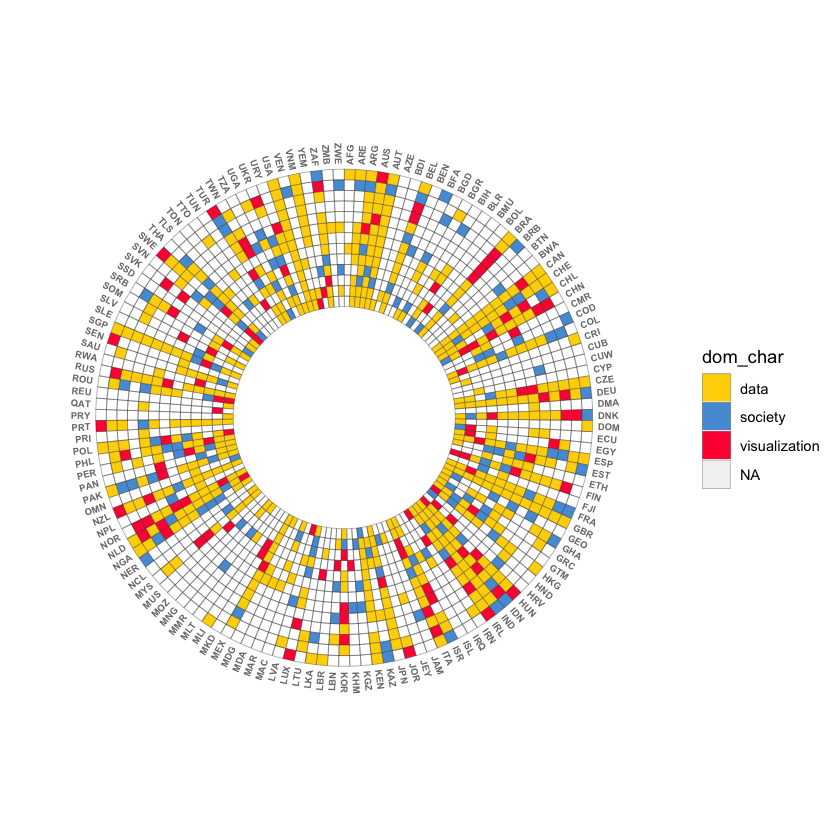

In [45]:
ggplot(res %>% filter(GID_0!="NA"), aes(x=GID_0, y=var2, fill=dom_char)) +
  geom_tile(colour="#333333") +
  scale_fill_manual(values = c("#FFD400", "#579CD9", "#FF1C41"), na.value = 'transparent')+
  # data: FF1C41; visualization: FFD400; society: 579CD9; outlines: 969696
  ylim(c(0, max(res$var2) + mar_value)) +
  #scale_y_discrete(breaks=y_breaks, labels=y_labels ) +
  coord_polar(start= 0 ) +
  geom_text(data=label_data, aes(x=GID_0, y=max(res$var2)+mar_value-1, label=GID_0, hjust=hjust), color="black", fontface="bold",alpha=0.6, size=2, angle= label_data$angle, inherit.aes = FALSE )+ 

  theme(panel.background = element_rect(fill = "transparent"),
        #, colour, size, linetype, color),
        axis.title=element_blank(),
        panel.grid=element_blank(),
        axis.text.x = element_blank(),

        axis.ticks=element_blank(),
        axis.text.y=element_blank())

In [ ]:
# ggsave("donut.svg")

## With full name and with space to add there the legend

In [46]:
country_names_code = d %>%
  select(GID_0,NAME_0) %>%
  group_by(GID_0,NAME_0) %>%
  summarize(count = length(GID_0))%>%
  as.data.frame()
head(country_names_code)
sum(is.na(country_names_code$GID_0))

Warning message:
“Factor `GID_0` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `NAME_0` contains implicit NA, consider using `forcats::fct_explicit_na`”

GID_0,NAME_0,count
AFG,Afghanistan,2
ARE,United Arab Emirates,19
ARG,Argentina,65
AUS,Australia,298
AUT,Austria,45
AZE,Azerbaijan,1


[1] 1

### Preparing labels
#### We will create new factor levels whose data will be `NA`

In [47]:
label_data_na = country_names_code %>%
# we have to change from factor to character to add levels
  mutate(GID_0 = as.character(GID_0), 
         NAME_0 = as.character(NAME_0))%>%
  mutate(GID_0 = replace(GID_0, is.na(GID_0),"NA"), 
         NAME_0 = replace(NAME_0, is.na(NAME_0),"NA"))%>%
# we are adding a new row with dummy data
  add_row(GID_0 = c("NA2", "NA3", "NA4"), 
          NAME_0 = c("NA2", "NA3", "NA4"))%>%
# we make the fields factors again
  mutate(GID_0 = as.factor(GID_0), 
         NAME_0= as.factor(NAME_0)) %>% 
# we lowercase the country names
  mutate(NAME_0 = tolower(NAME_0))

In [48]:
label_data_na$GID_0 = label_data_na$GID_0 %>%
# we reorder the levels using the number of members per country
  fct_reorder(desc(label_data_na$count))%>%
# we place the NA levels at the end of the factor levels
# this is so in the doughtnut they appear at the top
  fct_relevel( c("NA", "NA2", "NA3", "NA4"), after = Inf)

### Creating the hole

In [49]:
# calculate the ANGLE of the labels
number_of_bar <- nrow(label_data_na)
angle <-  90 - 360 * (as.numeric(label_data_na$GID_0)-0.5) /number_of_bar     # I substract 0.5 because the letter must have the angle of the center of the bars. Not extreme right(1) or extreme left (0)

# calculate the alignment of labels: right or left
# If I am on the left part of the plot, my labels have currently an angle < -90
label_data_na$hjust<-ifelse( angle < -90, 1, 0)

# flip angle BY to make them readable
label_data_na$angle<-ifelse(angle < -90, angle+180, angle)

#### We have to add the levels to the database and order them in the same way we have ordered the labels.

In [51]:
# We change the NA of GID_0 into a NA level
res_na = res %>% 
  mutate(GID_0 = as.character(GID_0))%>%
  mutate(GID_0 = replace(GID_0,is.na(GID_0),"NA"))%>%
  mutate(GID_0 = as.factor(GID_0)) %>%
  mutate(dom_char = replace(dom_char, GID_0=="NA",NA))

# We add the other NA levels we have created for the labels
res_na$GID_0 = res_na$GID_0 %>%
  fct_relevel( c("NA"), after = Inf) %>%
  fct_expand("NA2", "NA3", "NA4") %>%
  fct_reorder(desc(res_na$count)) %>%
  fct_relevel( c("NA","NA2", "NA3", "NA4"), after = Inf)

res_na = res_na%>%
# We use complete to have NA data for the NA levels we have added
  complete(nesting(month_num, month), GID_0)


In [52]:
# Convert the factor levels to numeric + quantity to determine size of hole.
res_na$var2 = as.numeric(res_na$month) + 15
mar_value = 2
ax <- length(unique(res_na$GID_0))

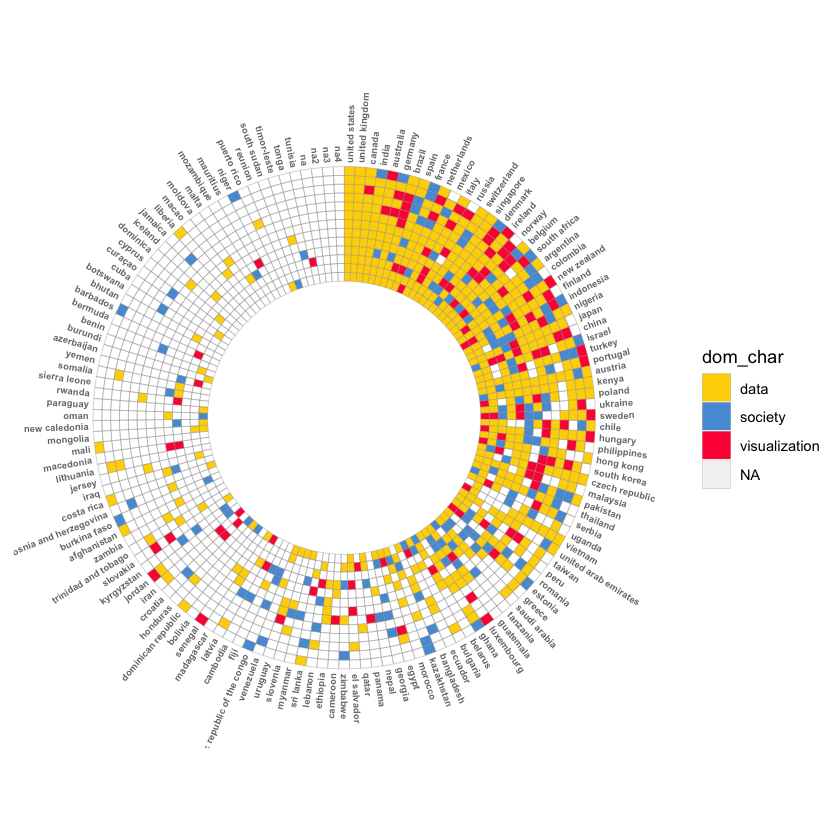

In [53]:
ggplot(res_na , aes(x=GID_0, y=var2, fill=dom_char)) +
  geom_tile(colour="#969696") +
  scale_colour_manual(na.value ="#969696")+
  scale_fill_manual(values = c("#FFD400", "#579CD9", "#FF1C41"), na.value = 'transparent')+
  # data: FF1C41; visualization: FFD400; society: 579CD9; outlines: 969696
  ylim(c(0, max(res_na$var2) + mar_value)) +
  #scale_y_discrete(breaks=y_breaks, labels=y_labels ) +
  coord_polar(start= 0 ) +
  geom_text(data=label_data_na, aes(x=GID_0, y=max(res_na$var2)+mar_value-1, label=NAME_0, hjust=hjust), 
  color="black", fontface="bold",alpha=0.6, size=2, angle= label_data_na$angle, inherit.aes = FALSE )+ 
  theme(panel.background = element_rect(fill = "transparent"),
        axis.title=element_blank(),
        panel.grid=element_blank(),
        axis.text = element_blank(),
        axis.ticks=element_blank())

In [54]:
# ggsave("donut_blank_lbls.svg")

#### the same plot but only with the data char shown

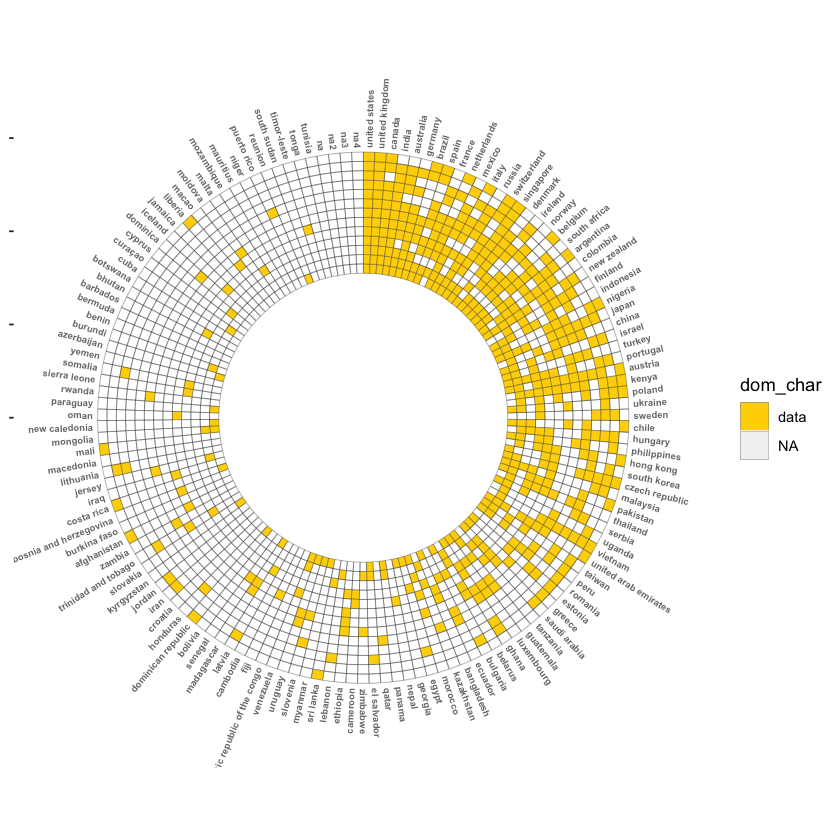

In [55]:
ggplot(res_na %>% #here is where we select the rows to show, by replacing the non data to NA
         mutate(dom_char = replace(dom_char,dom_char!="data",NA)), 
       aes(x=GID_0, y=var2, fill=dom_char)) +
  geom_tile(colour="#333333") +
  scale_fill_manual(values = c("#FFD400", "#579CD9", "#FF1C41"), na.value = 'transparent')+
  # data: FF1C41; visualization: FFD400; society: 579CD9; outlines: 969696
  #ylim(c(0, max(res$var2) + mar_value)) +
  scale_y_continuous(limits = c(0, max(res_na$var2) + mar_value)) +
  coord_polar(start= 0 ) +
  geom_text(data=label_data_na, aes(x=GID_0, y=max(res_na$var2)+mar_value-1, label=NAME_0, hjust=hjust), 
            color="black", fontface="bold",alpha=0.6, size=2, angle= label_data_na$angle, inherit.aes = FALSE )+
  theme(panel.background = element_blank(),#element_rect(fill = "#EDF4E9"),
        axis.title=element_blank(),
        #panel.grid.major = element_blank(),
        axis.text = element_blank(),
        panel.grid.minor = element_blank(),
        panel.grid.major = element_blank(),
        axis.text.y=element_blank())

#### the same plot but only with the visualisation char shown

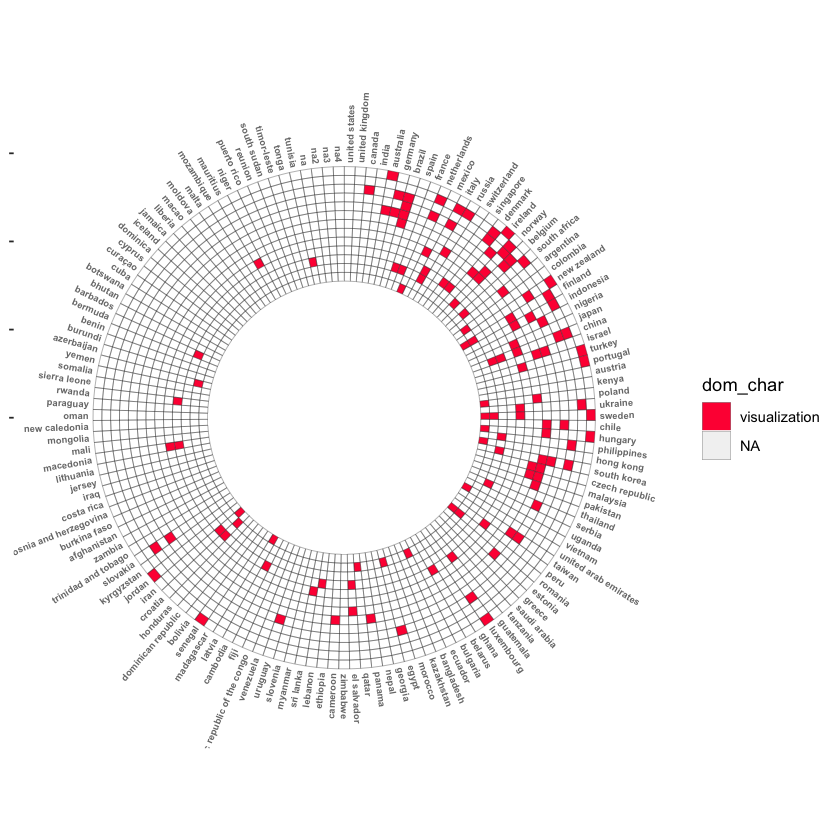

In [57]:
ggplot(res_na %>% 
         mutate(dom_char = replace(dom_char,dom_char!="visualization",NA)), 
       aes(x=GID_0, y=var2, fill=dom_char)) +
  geom_tile(colour="#333333") +
  scale_fill_manual(values = c("#FF1C41"), na.value = 'transparent')+
  # data: FF1C41; visualization: FFD400; society: 579CD9; outlines: 969696
  #ylim(c(0, max(res$var2) + mar_value)) +
  scale_y_continuous(limits = c(0, max(res_na$var2) + mar_value)) +
  coord_polar(start= 0 ) +
  geom_text(data=label_data_na, aes(x=GID_0, y=max(res_na$var2)+mar_value-1, label=NAME_0, hjust=hjust), 
            color="black", fontface="bold",alpha=0.6, size=2, angle= label_data_na$angle, inherit.aes = FALSE )+
  theme(panel.background = element_blank(),#element_rect(fill = "#EDF4E9"),
        axis.title=element_blank(),
        #panel.grid.major = element_blank(),
        axis.text = element_blank(),
        panel.grid.minor = element_blank(),
        panel.grid.major = element_blank(),
        axis.text.y=element_blank())


In [58]:
#ggsave("visualization.svg")

#### the same plot but only with the society char shown

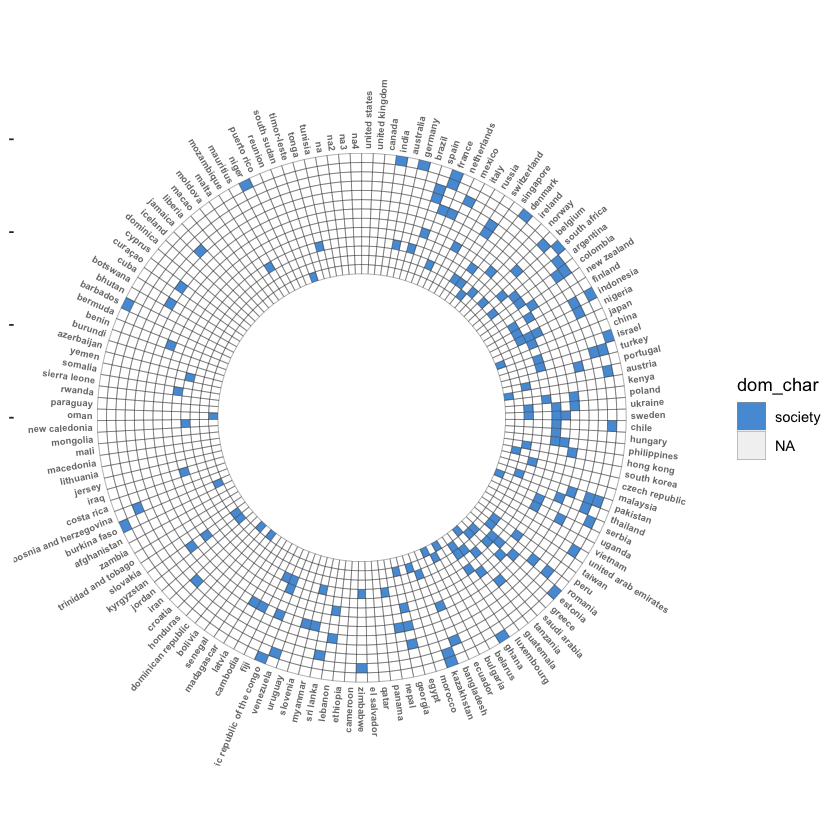

In [59]:
ggplot(res_na %>% 
         mutate(dom_char = replace(dom_char,dom_char!="society",NA)), 
       aes(x=GID_0, y=var2, fill=dom_char)) +
  geom_tile(colour="#333333") +
  scale_fill_manual(values = c("#579CD9"), na.value = 'transparent')+
  # data: FF1C41; visualization: FFD400; society: 579CD9; outlines: 969696
  #ylim(c(0, max(res$var2) + mar_value)) +
  scale_y_continuous(limits = c(0, max(res_na$var2) + mar_value)) +
  coord_polar(start= 0 ) +
  geom_text(data=label_data_na, aes(x=GID_0, y=max(res_na$var2)+mar_value-1, label=NAME_0, hjust=hjust), 
            color="black", fontface="bold",alpha=0.6, size=2, angle= label_data_na$angle, inherit.aes = FALSE )+
  theme(panel.background = element_blank(),#element_rect(fill = "#EDF4E9"),
        axis.title=element_blank(),
        #panel.grid.major = element_blank(),
        axis.text = element_blank(),
        panel.grid.minor = element_blank(),
        panel.grid.major = element_blank(),
        axis.text.y=element_blank())


In [60]:
#ggsave("society.svg")

## Looking at the countries with the most members

In [63]:
top50 = country_perc %>% 
  arrange(desc(count))%>% slice(1:50)
bot50 = country_perc %>% 
  arrange(count)%>% slice(1:50)
top10 = country_perc %>% 
  filter(!is.na(GID_0))%>% # for the top 10 the NA was included
  arrange(desc(count))%>% slice(1:10)
top4 = country_perc %>% 
  arrange(desc(count))%>% slice(1:4)

In [68]:
d_top_countries = d_char %>% 
  filter(GID_0%in%top10$GID_0) 
d_top_countries$GID_0 = d_top_countries$GID_0 %>% 
  fct_infreq

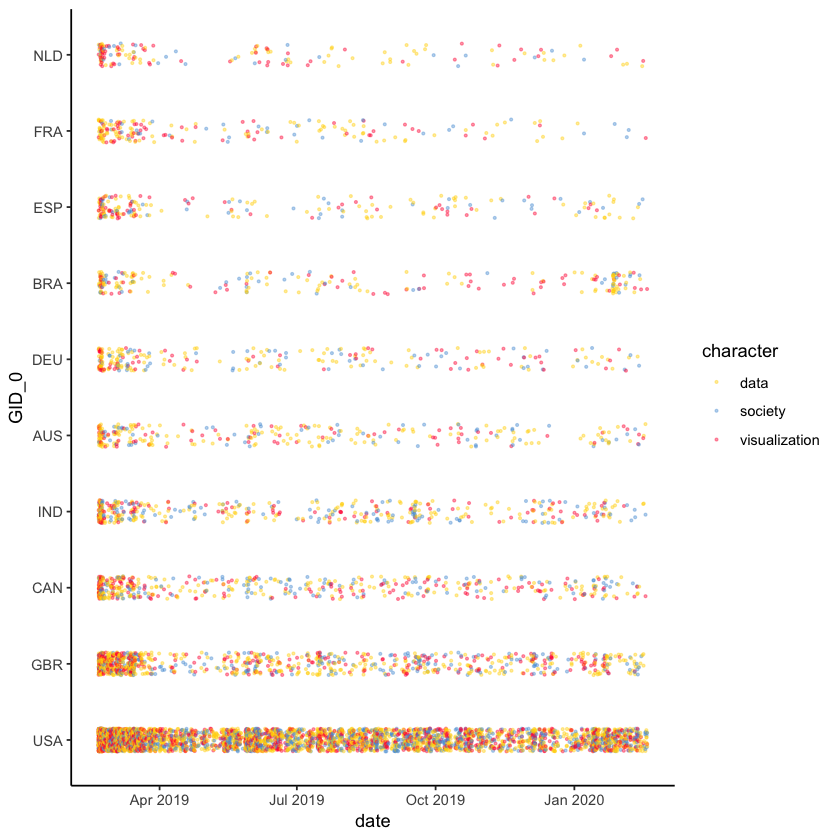

In [69]:
ggplot(d_top_countries)+
  geom_jitter(aes(x=GID_0, y = date, fill=character, colour=character), alpha = 0.4, shape = 21, size=0.5, width = 0.15)+
  scale_fill_manual(values = c("#FFD400", "#579CD9", "#FF1C41"))+
  scale_colour_manual(values = c("#FFD400", "#579CD9", "#FF1C41"))+
  theme_classic()+
  coord_flip()

In [ ]:
#ggsave("top10.svg")

## Looking at the top 4 countries variation by weeks
[getting the nth week of the month](https://stackoverflow.com/questions/25199851/r-how-to-get-the-week-number-of-the-month) 

In [70]:
# function to get the number of the week within a month
nth_week<- function(dates = NULL,
                    count_weeks_in = c("month","year"),
                    begin_week_on = "Monday"){

  require(lubridate)

  count_weeks_in<- tolower(count_weeks_in[1])

  # day_names and day_index are for beginning the week on a day other than Sunday
  # (this vector ordering matters, so careful about changing it)
  day_names<- c("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")

  # index integer of first match
  day_index<- pmatch(tolower(begin_week_on),
                     tolower(day_names))[1]


  ### Calculate week index of each day

  if (!is.na(pmatch(count_weeks_in, "year"))) {

    # For year:
    # sum the day of year, index for day of week at start of year, and constant 5 
    #  then integer divide quantity by 7   
    # (explicit on package so lubridate and data.table don't fight)
    n_week<- (5 + 
                lubridate::yday(dates) + 
                lubridate::wday(floor_date(dates, 'year'), 
                                week_start = day_index)
    ) %/% 7

  } else {

    # For month:
    # same algorithm as above, but for month rather than year
    n_week<- (5 + 
                lubridate::day(dates) + 
                lubridate::wday(floor_date(dates, 'month'), 
                                week_start = day_index)
    ) %/% 7

  }

  # naming very helpful for review
  names(n_week)<- paste0(lubridate::wday(dates,T), '-', dates)

  n_week

}

In [71]:
d_top4_countries = d_char %>% 
  filter(GID_0%in%top4$GID_0) %>%
  mutate(week_c = (nth_week(date, "month")))

In [72]:
# Convert the factor levels to numeric + quanity to determine size of hole.
d_top4_countries$var2 = as.numeric(d_top4_countries$week_c) + 15
mar_value = 2
ax <- length(unique(d_top4_countries$month))

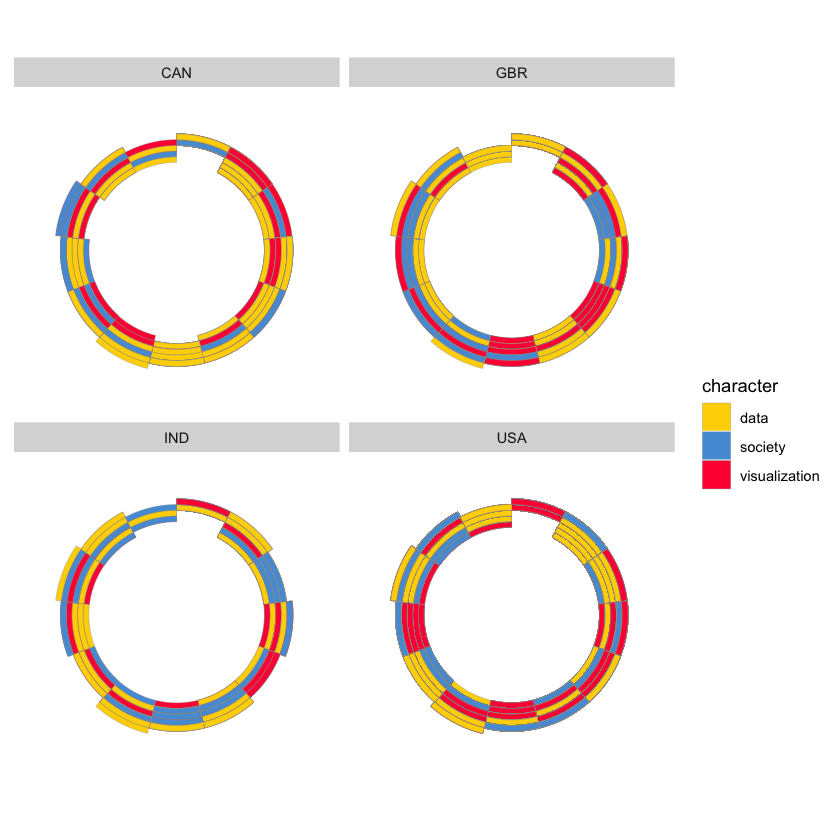

In [73]:
ggplot(d_top4_countries , aes(x=month, y=var2, fill=character)) +
  geom_tile(colour="#969696") +

  scale_colour_manual(na.value ="transparent")+
  scale_fill_manual(values = c("#FFD400", "#579CD9", "#FF1C41"), na.value = '#EDF4E9')+
  # data: FF1C41; visualization: FFD400; society: 579CD9; outlines: 969696
  ylim(c(0, max(d_top4_countries$var2) + mar_value)) +
  #scale_y_discrete(breaks=y_breaks, labels=y_labels ) +
  coord_polar(start= 0 ) +
  #geom_text(data=label_data_na, aes(x=GID_0, y=max(res_na$var2)+mar_value-1, label=GID_0, hjust=hjust), 
  #color="black", fontface="bold",alpha=0.6, size=2, angle= label_data_na$angle, inherit.aes = FALSE )+ 

  theme(panel.background = element_rect(fill = "transparent"),
        #, colour, size, linetype, color),
        axis.title=element_blank(),
        panel.grid=element_blank(),
        axis.text = element_blank(),
        axis.ticks=element_blank())+
  facet_wrap(~GID_0)

In [ ]:
#ggsave("/Users/gretacvega/Documents/GitHub/dvs/top4_weeks.svg")

# Flowers showing the percent of dominant character per month
heavily inspired by [this](https://github.com/jkaupp/tidytuesdays/blob/master/2019/week18/R/analysis.R)
## First try, pretty but not what we were looking for

In [74]:
plot_data = d_char %>%
  select(-GID_0, -week) %>%   
  mutate(month = month(date), year = year(date)) %>%
  group_by(month, year) %>% 
  count(month, character) %>%
  #group_by(month)%>%
  mutate(percent = n/sum(n)) %>% 
  mutate(percent = ifelse(is.nan(percent), 0, percent)) %>%
  mutate(month_num = as.numeric(month)) %>%
  complete(nesting(year, character), month = 1:12, fill = list(n = 0)) %>%
  mutate(percent = ifelse(is.na(percent), 0, percent))

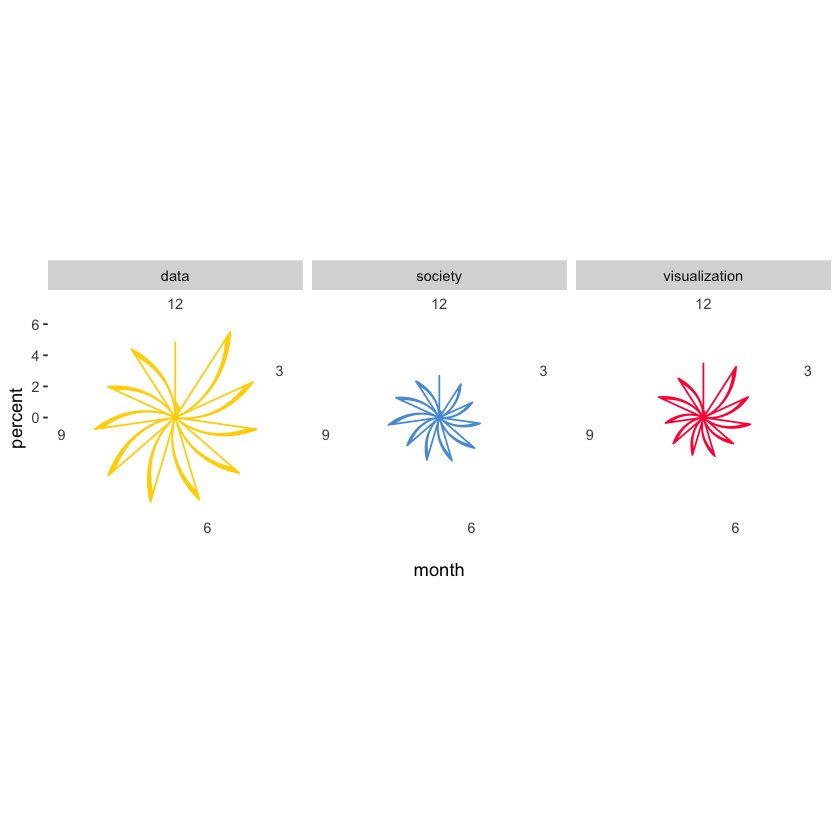

In [75]:
ggplot(plot_data, aes(x = month, y = percent, fill = character, colour=character)) +
  geom_area(size = 0.5) +
  scale_colour_manual(values = c("#FFD400", "#579CD9", "#FF1C41"), na.value = '#EDF4E9')+
  scale_fill_manual(values = c("#FFD400", "#579CD9", "#FF1C41"), na.value = '#EDF4E9')+
  #scale_x_continuous(labels = month.abb, breaks = 1:12)+    
  #geom_path(aes(color = character), size = 1, show.legend = TRUE) +
  coord_polar(theta = "x", start = 0) +

  facet_wrap(~character, drop = TRUE)+
  theme(panel.background = element_rect(fill = "transparent"),
        #, colour, size, linetype, color),
        #axis.title=element_blank(),
        panel.grid=element_blank(),
        #axis.text = element_blank(),
        #axis.ticks=element_blank(),
        legend.position = "none")


In [76]:
#ggsave("/Users/gretacvega/Documents/GitHub/dvs/pseudo_flowers.svg")

## Petals!
The issue was in having more than one value per month per character. So, as we had data for 2019, we had to create dummy data for 2018 and 2020. Also, we had to create extra points for the path for each character to start from 0 go to the percent value and then back to 0. For that we created new levels for the character values: they were 1, 2 and 3, so we created intermediate values with 0 as percent value. 

In [77]:
plot_data2 = 
  plot_data %>%
  select(-month_num, -n) %>%
  mutate(character_num = as.factor(character), character_num = as.numeric(character_num)) %>%
  select(-character) %>%
  as.data.frame() %>%
  add_row(year = c(2020,2019,2018, 2018), month = c(1:4), percent = rep(0,4), character_num = c(0.5,1.5,2.5,3.5))%>%
  mutate(character_num = as.factor(character_num))%>%
  complete(year, month, character_num, fill = list(percent = 0)) %>%
  #complete(nesting(year, month), character_num) %>%
  #complete(nesting(year, character_num), month) %>%
  mutate(year = as.factor(year), month= as.factor(month))%>%
  mutate(percent = ifelse(is.na(percent), 0, percent))

Warning message:
“Width not defined. Set with `position_dodge(width = ?)`”

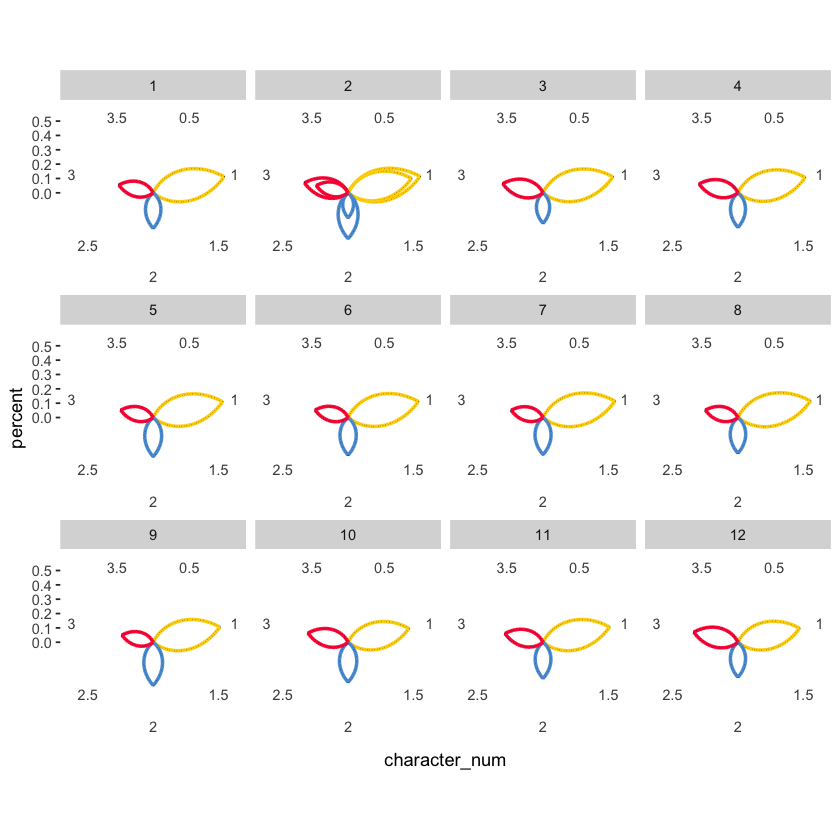

In [78]:
ggplot(plot_data2, aes(x = character_num, y = percent, group = year)) +
  geom_area(size = 0.5, position = position_dodge(),  fill = "transparent", colour="black") +
  scale_colour_manual(values = c("#FFD400","#FFD400", "#579CD9","#579CD9", "#FF1C41", "#FF1C41", "#FF1C41"), na.value = '#EDF4E9')+
  #scale_fill_manual(values = c("#FFD400", "#579CD9", "#FF1C41"), na.value = '#EDF4E9')+
  #scale_x_continuous(labels = month.abb, breaks = 1:12)+    
  geom_path(aes(color = character_num), size = 1, show.legend = TRUE) +
  coord_polar(theta = "x", start = 0) +

  facet_wrap(~month, drop = TRUE)+
  theme(panel.background = element_rect(fill = "transparent"),
        #, colour, size, linetype, color),
        #axis.title=element_blank(),
        panel.grid=element_blank(),
        #axis.text = element_blank(),
        #axis.ticks=element_blank(),
        legend.position = "none")



In [ ]:
#ggsave("/Users/gretacvega/Documents/GitHub/dvs/flowers.svg")

#### Showing the petals without differenciating months
I think I still don't know how `complete` works... 

In [79]:
xx =plot_data %>%
  select(-month_num, -n) %>%
  mutate(character_num = as.factor(character), character_num = as.numeric(character_num)) %>%
  select(-character) %>%
  as.data.frame() %>%
  add_row(year = c(2020,2019,2019, 2019), month = rep(1,4), percent = rep(0,4), character_num = c(0.5,1.5,2.5,3.5))%>%
  mutate(character_num = as.factor(character_num))%>%
  complete(year, month, character_num, fill = list(percent = 0)) %>%
  mutate(year = as.factor(year), month= as.factor(month))%>%
  mutate(percent = ifelse(is.na(percent), 0, percent))%>%
  mutate(ym = paste(year,month, sep = "_"))%>%
  filter(ym %in% c("2019_1","2019_2","2019_3","2019_4","2019_5","2019_6",  "2019_7","2019_8","2019_9","2019_10","2019_11","2019_12","2020_1","2020_2"))%>%
  group_by(character_num)%>%
  summarize(s = mean(percent))%>%
  mutate(year=1)%>%
  add_row(character_num = rep(0.5,2), s = rep(0,2), year =c(2,3))%>%
  complete(year, character_num, fill = list(s = 0))


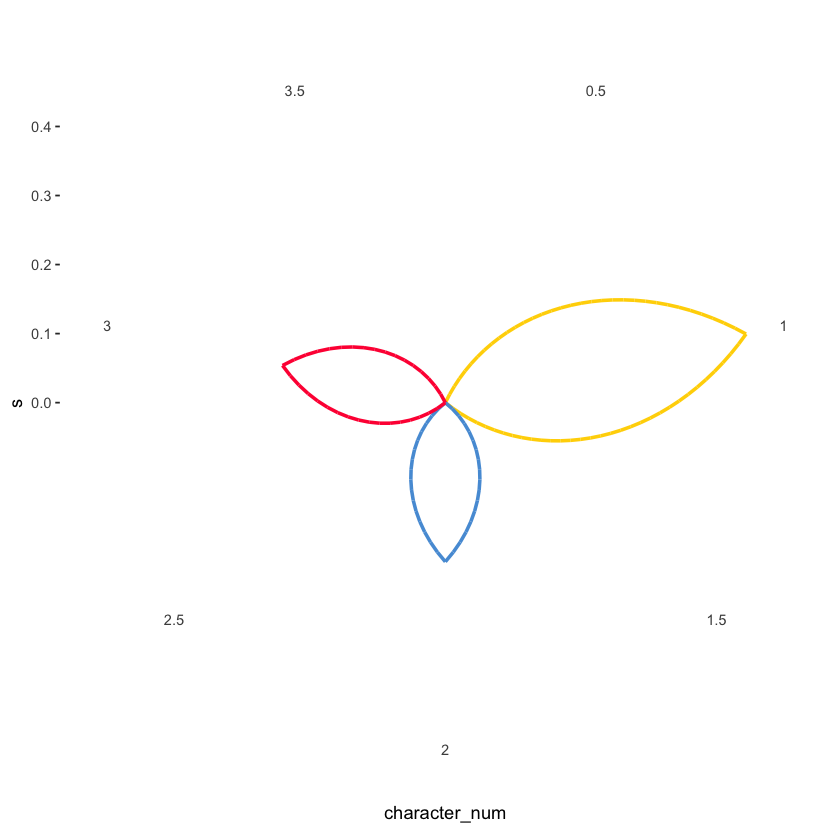

In [80]:
ggplot(xx, 
       aes(x = character_num, y = s, group = year)) +
  #geom_area( size = 0.5, position = position_dodge(),  fill = "transparent", colour="black") +
  scale_colour_manual(values = c("#FFD400","#FFD400", "#579CD9","#579CD9", "#FF1C41", "#FF1C41", "#FF1C41"), na.value = '#EDF4E9')+
  #scale_fill_manual(values = c("#FFD400", "#579CD9", "#FF1C41"), na.value = '#EDF4E9')+
  #scale_x_continuous(labels = month.abb, breaks = 1:12)+    
  geom_path(aes(color = character_num), size = 1, show.legend = TRUE) +
  coord_polar(theta = "x", start = 0) +  
  #facet_grid(month~year, drop = TRUE)+
  theme(panel.background = element_rect(fill = "transparent"),
        #, colour, size, linetype, color),
        #axis.title=element_blank(),
        panel.grid=element_blank(),
        #axis.text = element_blank(),
        #axis.ticks=element_blank(),
        legend.position = "none")


In [ ]:
#ggsave("/Users/gretacvega/Documents/GitHub/dvs/flowers_all.svg")